In [1]:
## 20240308 NF/FF Flights with fixed pulsing cadence over WLC... (use WLC Site named for each polarization!)
## Group 1: ch0=Bicolog, ch1=Telescope_Y_NSpol
    ## 'FLY001Airdata.csv' - Altitude ~60m, Yaw ~0deg  --> FFNS
    ## 'FLY002Airdata.csv' - Altitude ~10m, Yaw ~0deg   --> NFNS
## Group 2: ch0=Telescope_X_EWpol, ch1=Bicolog
    ## 'FLY003Airdata.csv' - Altitude ~10m, Yaw ~90deg  --> NFEW
    ## 'FLY004Airdata.csv' - Altitude ~60m, Yaw ~90deg --> FFEW

import h5py, datetime, pytz,os,glob,pandas,csv, pickle, matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
from matplotlib import colors
import numpy as np
from scipy.interpolate import griddata
from scipy.optimize import least_squares
from scipy.optimize import curve_fit

%matplotlib inline
import beamcals
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import beammap
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu

from beamcals.sites import site
wlcsiteEW=site.site('../../newburghlabdrone/beamcals/beamcals/sites/WLC_config_EW20230519.npz')
wlcsiteNS=site.site('../../newburghlabdrone/beamcals/beamcals/sites/WLC_config_NS20230519.npz')

#phase unwrap:
from skimage.restoration import unwrap_phase

# Display settings:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


In [2]:
##  NF2FF Instructions
##  1. Preparation and Preliminary Measurements
##  2. Design a Flightpath optimized for NF Sampling 
##  3. Execute testflights and collect data
##  4. Analyze data using the Drone, Corr, and Concat Classes
##  5. Produce yaml, gfit, and pickle files of reduced data
##  6. Initialize the beammap class for each flight using the 0x1 (cross) data
##  7. Interpolate beammap data so that every cell contains data
##  8. Trim the interpolated beammap so that no nans are present
##  9. Execute the unwrap function on the interpolated data to unwrap the phase
## 10. Perform fit on the wrapped/unwrapped phase measurements
## 11. Subtract best-fit geometric phase from the unwrapped phase to obtain residual AUT phase
## 12. Reconstruct E-Field from AUT by complexifying the sqrt(auto=0x0) with the residual AUT phase

## Laura's notes:
# are we required ot have a SQUARE grid for NF maps?
# I am not convinced about that 0x0 amplitude for reconstructing the E-field. Could believe sqrt(auto1**2 + auto2**2), etc
# Right now the beam map is done for all frequencies, but further analysis is restricted per-freq. Probably theres a clever 
# way of handling this. 


In [3]:
#Define some nice functions for this notebook: we use this to fit the phase fringes

def unwrap2d(phi_arr,wrap_args=(False,False)):
    naninds=np.isnan(phi_arr)
    mask_arr=np.zeros_like(phi_arr,dtype=bool)
    mask_arr[naninds]=True    
    phi_mask=np.ma.array(phi_arr,mask=mask_arr)
    phi_mask[naninds]=0.0
    phi_unwrap=unwrap_phase(phi_mask,wrap_around=wrap_args) # use scikit to unwrap 2D phase
    phi_out=phi_unwrap.data-np.nanmean(phi_unwrap.data)
    phi_out[naninds]=np.nan
    phi_arr[naninds]=np.nan
    return(phi_out)

# Solve for ABC st (drnpos•[A,B,C])==np.angle(V01) for drnpos in cut boundaries where geometric 
# phase contribution is nonnegligible


def Fringe_Fit(P,dronepos,V,wavelengthm):
    A,B,C,G=P
    phi=(2.0*np.pi/wavelengthm)*((A*(dronepos[:,0]))+(B*(dronepos[:,1]))+(C*(dronepos[:,2])))
    return phi-V


def Fringe(P,dronepos,wavelengthm):
    A,B,C,G=P
    phi=(2.0*np.pi/wavelengthm)*((A*(dronepos[:,0]))+(B*(dronepos[:,1]))+(C*(dronepos[:,2])))
    return phi


In [4]:
def plot_pickle(concat, find, chind0, chind1): 
    fig,[ax1,ax2,ax3,ax4]=subplots(nrows=1,ncols=4,figsize=(16,9))
    ax1.scatter(concat.drone_xyz_per_dish_interp[chind0,t_cut,0],
                     concat.drone_xyz_per_dish_interp[chind0,t_cut,1],
                     c=concat.V_bgsub[t_cut,find,chind0],cmap=cm.gnuplot2,norm=LogNorm())
    ax2.scatter(concat.drone_xyz_per_dish_interp[chind1,t_cut,0],
                     concat.drone_xyz_per_dish_interp[chind1,t_cut,1],
                     c=concat.V_bgsub[t_cut,find,chind1],cmap=cm.gnuplot2,norm=LogNorm())
    ax3.scatter(concat.drone_xyz_per_dish_interp[chind0,t_cut,0],
                     concat.drone_xyz_per_dish_interp[chind0,t_cut,1],
                     c=concat.V_cross_bgsub[t_cut,find,0].real,cmap=cm.gnuplot2)
    ax4.scatter(concat.drone_xyz_per_dish_interp[chind0,t_cut,0],
                     concat.drone_xyz_per_dish_interp[chind0,t_cut,1],
                     c=concat.V_cross_bgsub[t_cut,find,0].imag,cmap=cm.gnuplot2)

    titles=['ch amp','chx real', 'chx imag']
    for i,ax in enumerate([ax1,ax2,ax3]):
        ax.set_xlabel('x [m]')
        ax.set_ylabel('y [m]')
    tight_layout()
    
def get_bounds(beam,bou,vplot=True):
    # find the iteration equivalent to this bound
    ximin = np.argmin(abs(-1*bou - beam.d0_centers_grid[:,0,0]))
    ximax = np.argmin(abs(bou - beam.d0_centers_grid[:,0,0]))
    yimin = np.argmin(abs(-1*bou - beam.d1_centers_grid[0,:,0]))
    yimax = np.argmin(abs(bou - beam.d1_centers_grid[0,:,0]))
    
    xmin,xmax,ymin,ymax=[beam.d0_centers_grid[ximin,0,0],beam.d0_centers_grid[ximax,0,0],
                        beam.d1_centers_grid[0,yimin,0],beam.d1_centers_grid[0,yimax,0]]
    
    if vplot==True:
        fig,[[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]]=subplots(nrows=2,ncols=4,figsize=(16,9))
        ax1.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],beam.V_LC_cross.real[:,:,find,0,0])
        ax2.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],beam.V_LC_cross.imag[:,:,find,0,0])
        ax3.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],np.abs(beam.V_LC_cross)[:,:,find,0,0])#,norm=LogNorm())
        ax4.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],np.angle(beam.V_LC_cross)[:,:,find,0,0])

        ax5.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],beam.beam_linear_interp.real[:,:,find,0])
        ax6.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],beam.beam_linear_interp.imag[:,:,find,0])
        ax7.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],beam.beam_linear_interp_amp[:,:,find,0])#,norm=LogNorm())
        ax8.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],beam.beam_linear_interp_phase[:,:,find,0])

        titles=['real','imag','mag','phase','interp_real','interp_imag','interp_mag','interp_phase']
        for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]):
            ax.set_xlabel('x [m]')
            ax.set_ylabel('y [m]')
            ax.axvline(xmin)
            ax.axhline(ymin)
            ax.axvline(xmax)
            ax.axhline(ymax)
        tight_layout()
    
    return [ximin,ximax,yimin,yimax]

def cut_to_bounds(beam, xmin,xmax,ymin,ymax):
    beam.beam_linear_interp=beam.beam_linear_interp[xmin:xmax,ymin:ymax]
    beam.beam_linear_interp_amp=beam.beam_linear_interp_amp[xmin:xmax,ymin:ymax]
    beam.beam_linear_interp_phase=beam.beam_linear_interp_phase[xmin:xmax,ymin:ymax]
    beam.beam_linear_interp_phase_unwrapped=beam.beam_linear_interp_phase_unwrapped[xmin:xmax,ymin:ymax]
    beam.histogram_LC=beam.histogram_LC[xmin:xmax,ymin:ymax]
    beam.V_LC_cross=beam.V_LC_cross[xmin:xmax,ymin:ymax]
    beam.V_LC_mean=beam.V_LC_mean[xmin:xmax,ymin:ymax]
    beam.V_LC_operation=beam.V_LC_operation[xmin:xmax,ymin:ymax]
    beam.V_LC_std=beam.V_LC_std[xmin:xmax,ymin:ymax]
    beam.d0_centers_grid=beam.d0_centers_grid[xmin:xmax,ymin:ymax]
    beam.d0_edges_grid=beam.d0_edges_grid[xmin:xmax,ymin:ymax]
    beam.d1_centers_grid=beam.d1_centers_grid[xmin:xmax,ymin:ymax]
    beam.d1_edges_grid=beam.d1_edges_grid[xmin:xmax,ymin:ymax]
    
    beam.d0_centers=beam.d0_centers[xmin:xmax]
    beam.d0_edges=beam.d0_edges[xmin:xmax]
    beam.d1_centers=beam.d1_centers[ymin:ymax]
    beam.d1_edges=beam.d1_edges[ymin:ymax]
    
def get_unwrapped_phase(beam):
    phi_data=np.angle(beam.V_LC_cross[:,:,find,0,0])
    phi_data_unwrap=unwrap2d(phi_data,wrap_args=(False,True))
    phi_interp=beam.beam_linear_interp_phase[:,:,find,0]
    phi_interp_unwrap=unwrap2d(phi_interp,wrap_args=(False,True))
    return phi_data,phi_data_unwrap,phi_interp,phi_interp_unwrap

def plot_unwrapped_phases(beam,phi_data,phi_data_unwrap,phi_interp,phi_interp_unwrap):
    fig,[ax1,ax2,ax3,ax4]=subplots(nrows=1,ncols=4,figsize=(16,4))
    im1=ax1.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],phi_data,cmap='gnuplot2')
    im2=ax2.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],phi_data_unwrap,cmap='gnuplot2')
    im3=ax3.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],phi_interp,cmap='gnuplot2')
    im4=ax4.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],phi_interp_unwrap,cmap='gnuplot2')
    images=[im1,im2,im3,im4]
    titles=["pcm no interp no unwrap","pcm no interp yes unwrap","pcm yes interp no unwrap","pcm yes interp yes unwrap"]
    cbarlabels=["$\phi$","$\phi$","$\phi$","$\phi$"]
    for j,ax in enumerate([ax1,ax2,ax3,ax4]):
        ax.set_title(titles[j])
        ax.set_facecolor('k')
        ax.set_xlabel('$x,[m]$')
        ax.set_ylabel('$y, [m]$')
        divider=make_axes_locatable(ax)
        cax=divider.append_axes("right", size="3%", pad=0.05)
        cbar=fig.colorbar(images[j],cax=cax)
        cbar.set_label(cbarlabels[j])
    tight_layout()
    
def get_complexE_remove_geom_phase(beam,find,vplot=True):
    dx=beam.d0_centers_grid[:,:,0]
    dy=beam.d1_centers_grid[:,:,0]
    wl=(3.0e8/(beam.freq[find]*1e6)) # keep this in m if you don't want everything to break!!
    dc=(beam.V_LC_cross[:,:,find,0,0]).flatten()
    dcabs=np.abs(beam.V_LC_cross[:,:,find,0,0]).flatten()

    dcang=phi_interp_unwrap.flatten()

    dcoords=np.zeros((dx.shape[0]*dx.shape[1],3))
    dcoords[:,0]=dx.flatten()
    dcoords[:,1]=dy.flatten()
    dcoords[:,2]=(100*np.ones((dx.shape[0]*dx.shape[1]))).flatten()
    unitvects=dcoords*np.outer(np.nansum((dcoords)**2.0,axis=1)**-0.5,np.ones(3))

    popt=least_squares(Fringe_Fit,x0=np.array([0.0,0.0,0.0,0.0]),args=[unitvects[~np.isnan(dcang)],dcang[~np.isnan(dcang)],wl]).x
    print("(A,B,C)=({:f},{:f},{:f})".format(popt[0],popt[1],popt[2]))
    print("G={:.3f}".format(popt[3]))

    if vplot==True:
        fig1,[ax1,ax2]=subplots(nrows=2,ncols=1,figsize=(16,10))
        ax1.plot(dcoords[:,0],phi_interp.flatten(),'.',alpha=0.5,markersize=5,label='phase from interpolated data')
        ax1.plot(dcoords[:,0],phi_data.flatten(),'.',alpha=0.5,markersize=20,label='phase from uninterpolated data')
        ax1.legend(loc=2,framealpha=1)
        ax2.plot(dcoords[:,0],dcang,'.',alpha=0.5,markersize=2,label='unwrapped phase from data')
        ax2.plot(dcoords[:,0],Fringe(np.array(popt),unitvects,wl),'^',alpha=0.5,markersize=5,label='estimated unwrapped phase from model')
        ax2.legend(loc=2,framealpha=1)
        tight_layout()
        
        fig1,[ax1,ax2,ax3,ax4]=subplots(nrows=1,ncols=4,figsize=(16,4))
        im1=ax1.scatter(dx,dy,s=50,c=dcang,cmap='gnuplot2')
        im2=ax2.scatter(dx,dy,s=50,c=Fringe(popt,unitvects,wl),cmap='gnuplot2')
        im3=ax3.scatter(dx,dy,s=50,c=(dcang-Fringe(popt,unitvects,wl)),cmap='gnuplot2')
        ax4.plot(dcoords[:,0],dcang,'.')
        ax4.plot(dcoords[:,0],Fringe(np.array(popt),unitvects,wl),'.')
        images=[im1,im2,im3]
        cbars=['$\phi$ [$rad$]','$\phi$ [$rad$]','$\phi$ [$rad$]']
        titles=["Data","Fit","Residuals","Phase Time Series"]
        for i,ax in enumerate([ax1,ax2,ax3]):
            ax.set_facecolor("k")
            ax.set_xlabel('X Position $[m]$')
            ax.set_ylabel('Y Position $[m]$')
            divider=make_axes_locatable(ax)
            cax=divider.append_axes("right", size="3%", pad=0.05)
            cbar=fig1.colorbar(images[i],cax=cax)
            cbar.set_label(cbars[i])
        for i,ax in enumerate([ax1,ax2,ax3,ax4]):
            ax.set_title(titles[i])
        ax4.set_xlabel("x [m]")
        ax4.set_ylabel("$\phi$ [rad]")
        tight_layout()
        
    else:''
    ampl=beam.beam_linear_interp_amp[:,:,find,0]
    phase=phi_interp_unwrap-Fringe(popt,unitvects,wl).reshape(dx.shape) # this should be the residual phase: data - geom. fit
    return ampl*np.exp(1.0j*phase)


In [5]:
# pick some parameters
find = 331
chind = 0

# First, assume the flight has been processed and pickled
pckldir="/hirax/NF2FF/20240308_WLC_NFandFF/products/pickles/"
gfitdir="/hirax/NF2FF/20240308_WLC_NFandFF/products/gfits/"
yamlfile = "../metadata/20240308_WLC_flights_forscripts.yaml"

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(gfitdir))

In [6]:
# Automate, as much as possible, generating the complex E-field

<_io.BufferedReader name='/hirax/NF2FF/20240308_WLC_NFandFF/products/pickles/FLY002Airdata_20240308T183549Z_ver_20240409T154916_concat.pkl'>
(50816, 1024, 2)
start of concat loop is: 2025-06-12 13:51:44.471102


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beammap.py:307: RuntimeWarning: divide by zero encountered in reciprocal
  Vvals=(np.repeat(np.swapaxes(g_norm[:,self.fmin:self.fmax:self.fstep],0,1)[np.newaxis,:,:],len(ccc.inds_on),axis=0)**-1)*ccc.V_bgsub[ccc.inds_on,self.fmin:self.fmax:self.fstep,:]
/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beammap.py:307: RuntimeWarning: invalid value encountered in multiply
  Vvals=(np.repeat(np.swapaxes(g_norm[:,self.fmin:self.fmax:self.fstep],0,1)[np.newaxis,:,:],len(ccc.inds_on),axis=0)**-1)*ccc.V_bgsub[ccc.inds_on,self.fmin:self.fmax:self.fstep,:]
/home/ln267/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:609: RuntimeWarning: invalid value encountered in subtract
  delta = values[vv] - flatsum[binnumbers] / flatcount[binnumbers]


end of concat loop is: 2025-06-12 13:52:43.14793024,           


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beammap.py:368: RuntimeWarning: Mean of empty slice
  self.V_LC_operation=np.nanmean(self.V_LC_mean,axis=4)


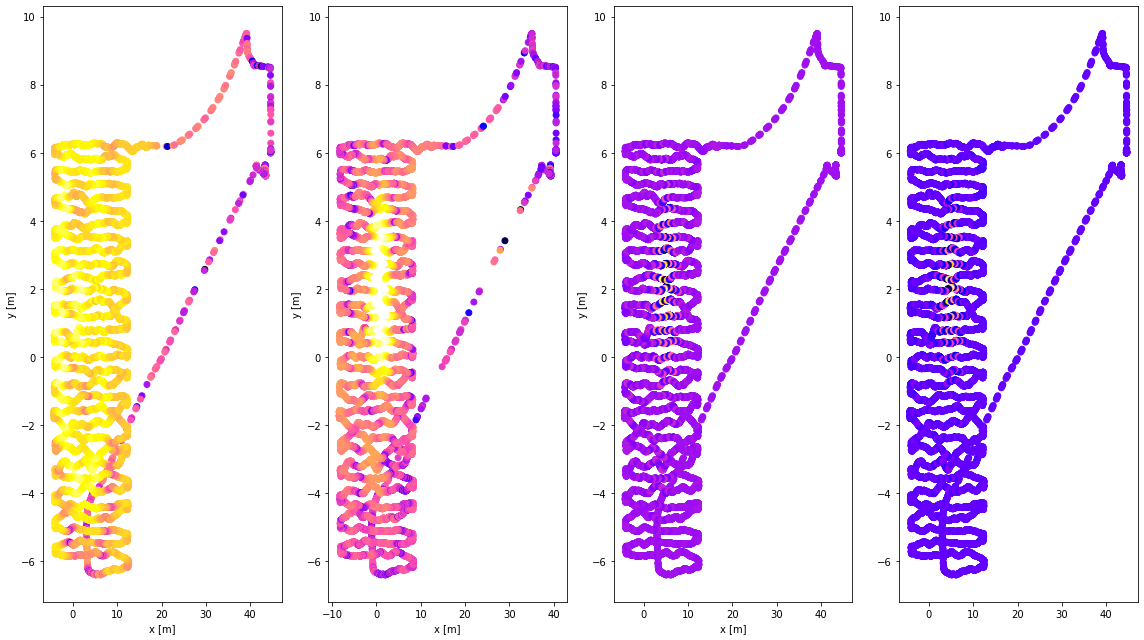

In [7]:
Pol1flight = pcklarr[1]
Pol1gains = gfitarr[1]

with open(pckldir+Pol1flight, 'rb') as pfile:
    print(pfile)
    concatff=pickle.load(pfile)
t_cut=concatff.inds_on    
print(concatff.V_bgsub.shape) # time, freq, input

plot_pickle(concatff, find, 0, 1)

## Now, pixelize and interpolate
beam=beammap.Beammap(concatlist=[Pol1flight],gfitlist=[Pol1gains],\
                         d0args=[-10,10,0.15],d1args=[-10,10,0.15],f_index_cc=360,\
                         normalization='Gauss',operation='coadd',
                         pickle_directory=pckldir,\
                         gfit_directory=gfitdir,\
                         flightmasterpath=yamlfile,\
                         vplot=False,include_cross_data=True)

beam.complex_interpolation(d0_interp=beam.d0_centers[:,0], d1_interp=beam.d1_centers[:,0],
                           method='cubic',variogram_model='spherical',outputs=False,Fargs=[find,find])

<ipython-input-4-0b40c32ec1bd>:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],beam.V_LC_cross.real[:,:,find,0,0])
<ipython-input-4-0b40c32ec1bd>:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax2.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],beam.V_LC_cross.imag[:,:,find,0,0])
<ipython-input-4-0b40c32ec1bd>:36: MatplotlibDeprecationWarning: shading='flat' when X

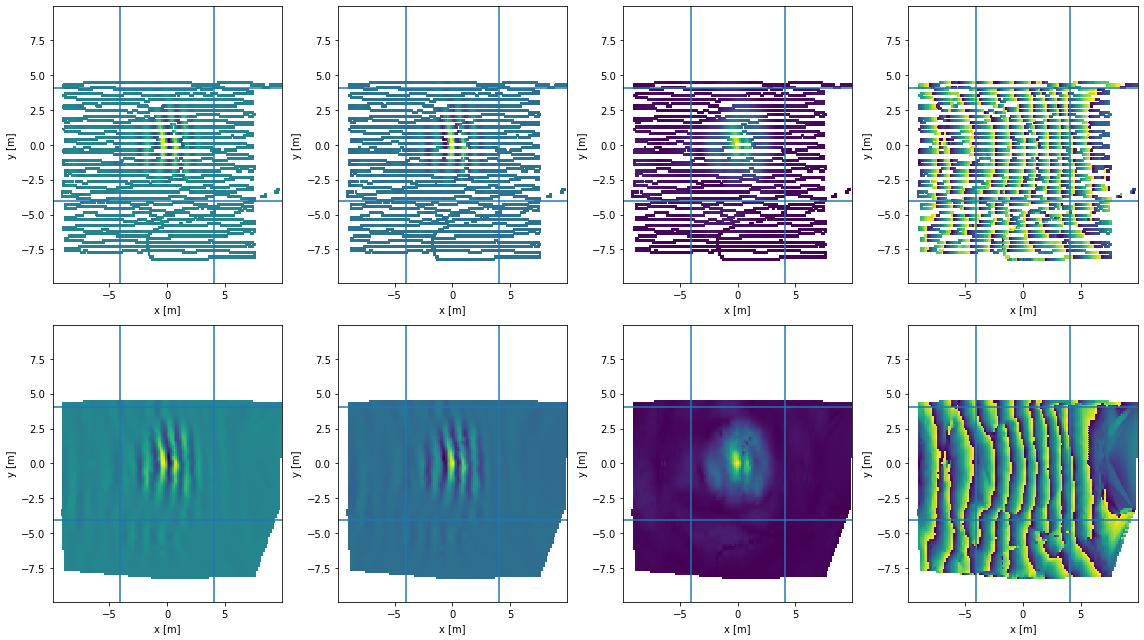

In [8]:
# Find the correct bounds
bou = 4
[xmin,xmax,ymin,ymax] = get_bounds(beam, bou,vplot=True)

In [9]:
# now can cut by bounds
cut_to_bounds(beam,xmin,xmax,ymin,ymax)

<ipython-input-4-0b40c32ec1bd>:85: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1=ax1.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],phi_data,cmap='gnuplot2')
<ipython-input-4-0b40c32ec1bd>:86: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2=ax2.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],phi_data_unwrap,cmap='gnuplot2')
<ipython-input-4-0b40c32ec1bd>:87: MatplotlibDeprecationWarning: shading='flat' when X and 

(A,B,C)=(36.030071,1.655935,0.028351)
G=0.000


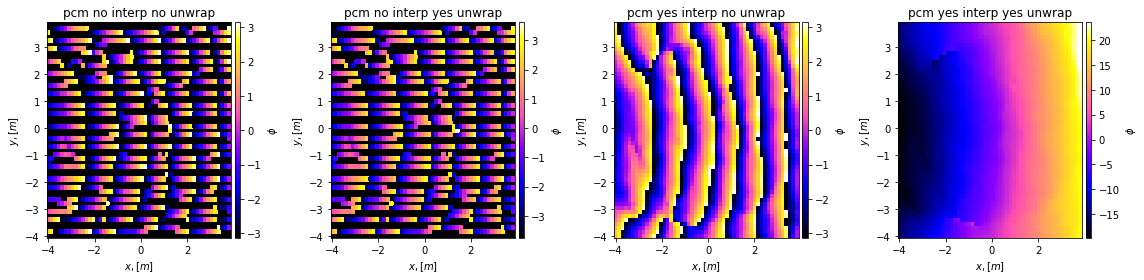

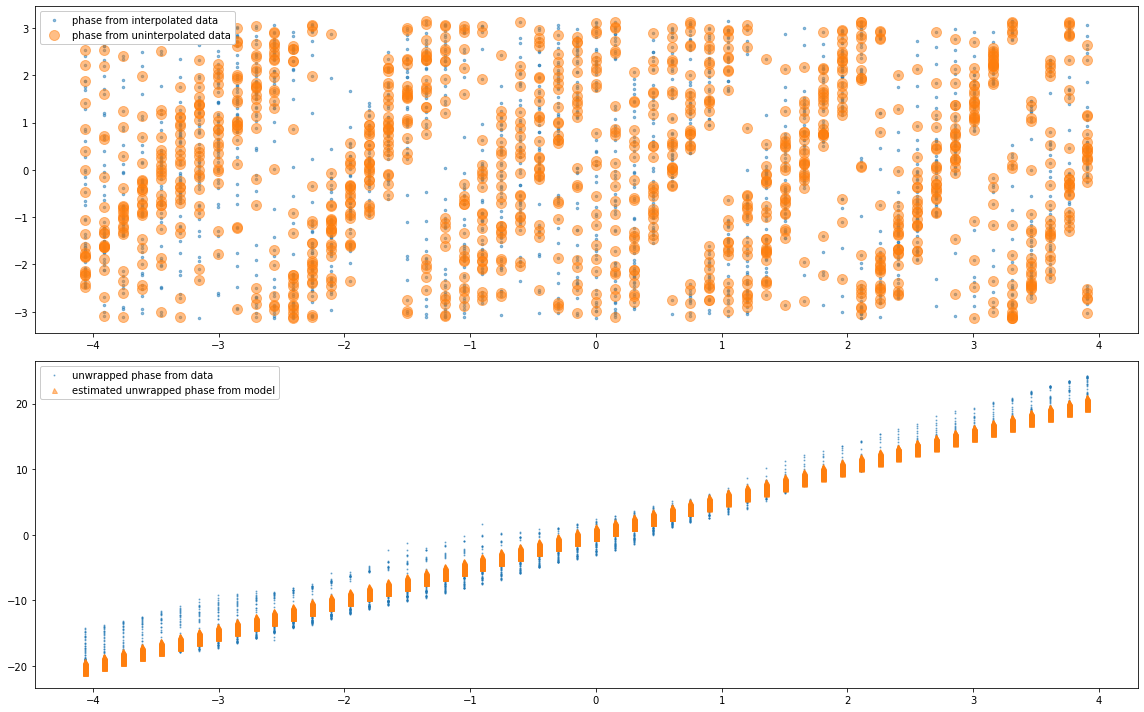

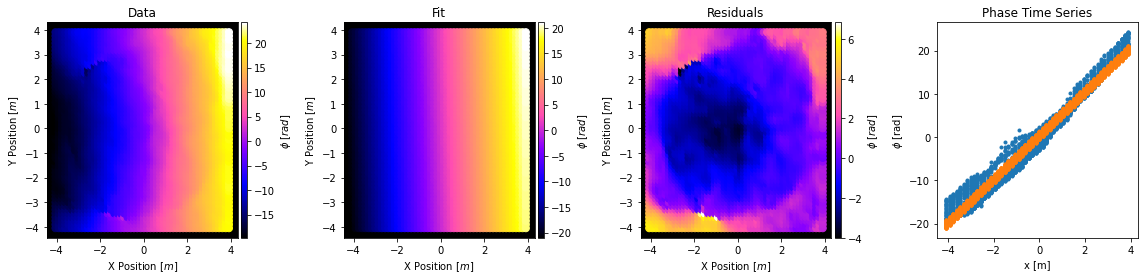

In [10]:
# get unwerapped phase and plot for data and interpolated data
phi_data,phi_data_unwrap,phi_interp,phi_interp_unwrap = get_unwrapped_phase(beam)
plot_unwrapped_phases(beam,phi_data,phi_data_unwrap,phi_interp,phi_interp_unwrap)

# if this looks good, go ahead and make a complex E field from it
cplxEfield1 = get_complexE_remove_geom_phase(beam,find,vplot=True)

<_io.BufferedReader name='/hirax/NF2FF/20240308_WLC_NFandFF/products/pickles/FLY003Airdata_20240308T191730Z_ver_20240409T161221_concat.pkl'>
(57344, 1024, 2)
beam mapping
start of concat loop is: 2025-06-12 14:11:04.819772


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beammap.py:307: RuntimeWarning: divide by zero encountered in reciprocal
  Vvals=(np.repeat(np.swapaxes(g_norm[:,self.fmin:self.fmax:self.fstep],0,1)[np.newaxis,:,:],len(ccc.inds_on),axis=0)**-1)*ccc.V_bgsub[ccc.inds_on,self.fmin:self.fmax:self.fstep,:]
/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beammap.py:307: RuntimeWarning: invalid value encountered in multiply
  Vvals=(np.repeat(np.swapaxes(g_norm[:,self.fmin:self.fmax:self.fstep],0,1)[np.newaxis,:,:],len(ccc.inds_on),axis=0)**-1)*ccc.V_bgsub[ccc.inds_on,self.fmin:self.fmax:self.fstep,:]
/home/ln267/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:609: RuntimeWarning: invalid value encountered in subtract
  delta = values[vv] - flatsum[binnumbers] / flatcount[binnumbers]


end of concat loop is: 2025-06-12 14:12:11.95033224,           


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beammap.py:368: RuntimeWarning: Mean of empty slice
  self.V_LC_operation=np.nanmean(self.V_LC_mean,axis=4)


interpolating


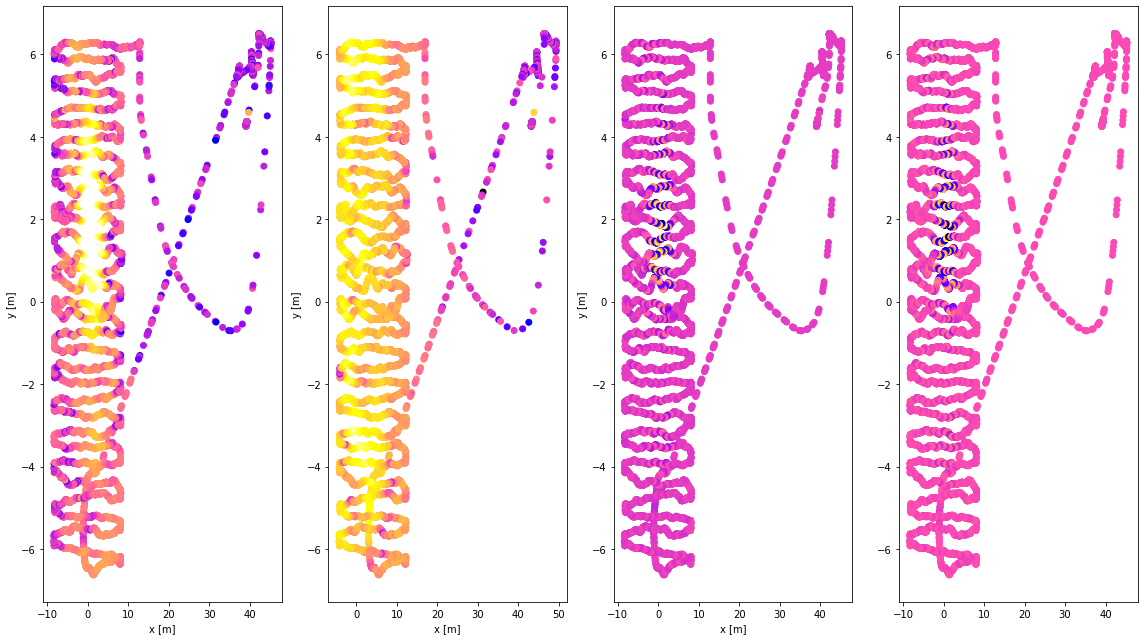

In [16]:
## Let's try this with the other NF flight:
Pol2flight = pcklarr[2]
Pol2gains = gfitarr[2]

with open(pckldir+Pol2flight, 'rb') as pfile:
    print(pfile)
    concatff=pickle.load(pfile)
t_cut=concatff.inds_on    
print(concatff.V_bgsub.shape) # time, freq, input

plot_pickle(concatff, find, 0, 1)

## Now, pixelize and interpolate
print('beam mapping')
beam=beammap.Beammap(concatlist=[Pol2flight],gfitlist=[Pol2gains],\
                         d0args=[-10,10,0.15],d1args=[-10,10,0.15],f_index_cc=360,\
                         normalization='Gauss',operation='coadd',
                         pickle_directory=pckldir,\
                         gfit_directory=gfitdir,\
                         flightmasterpath=yamlfile,\
                         vplot=False,include_cross_data=True)
print('interpolating')
beam.complex_interpolation(d0_interp=beam.d0_centers[:,0], d1_interp=beam.d1_centers[:,0],
                           method='cubic',variogram_model='spherical',outputs=False,Fargs=[find,find])

<ipython-input-4-0b40c32ec1bd>:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],beam.V_LC_cross.real[:,:,find,0,0])
<ipython-input-4-0b40c32ec1bd>:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax2.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],beam.V_LC_cross.imag[:,:,find,0,0])
<ipython-input-4-0b40c32ec1bd>:36: MatplotlibDeprecationWarning: shading='flat' when X

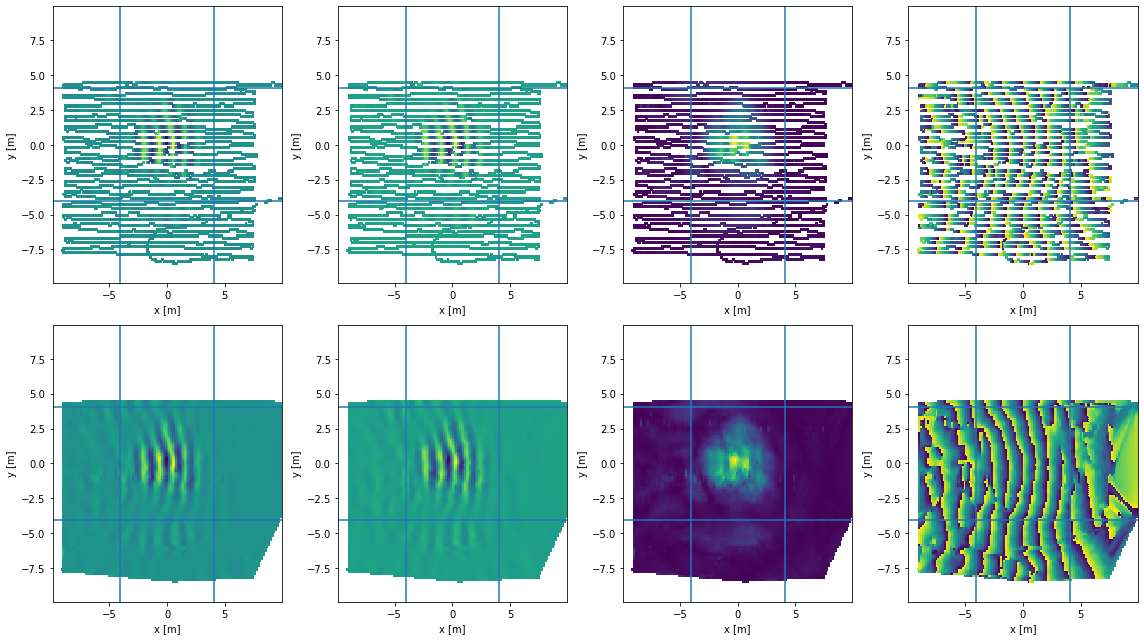

In [18]:
# Find the correct bounds
bou = 4
[xmin,xmax,ymin,ymax] = get_bounds(beam, bou,vplot=True)

In [19]:
# now can cut by bounds
cut_to_bounds(beam,xmin,xmax,ymin,ymax)


<ipython-input-4-0b40c32ec1bd>:85: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1=ax1.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],phi_data,cmap='gnuplot2')
<ipython-input-4-0b40c32ec1bd>:86: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2=ax2.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],phi_data_unwrap,cmap='gnuplot2')
<ipython-input-4-0b40c32ec1bd>:87: MatplotlibDeprecationWarning: shading='flat' when X and 

(A,B,C)=(-33.205218,-0.357656,-0.025255)
G=0.000


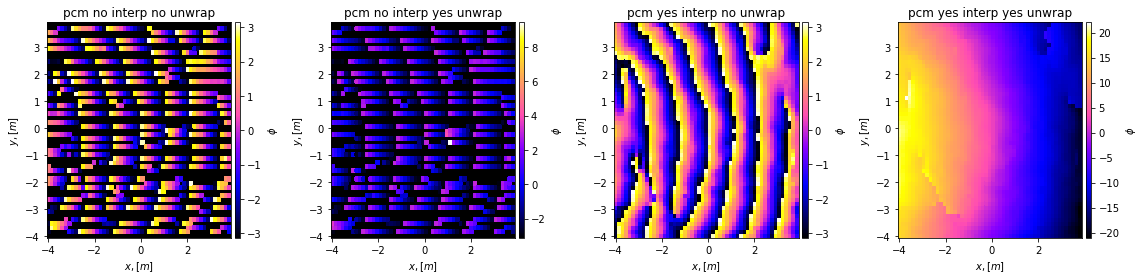

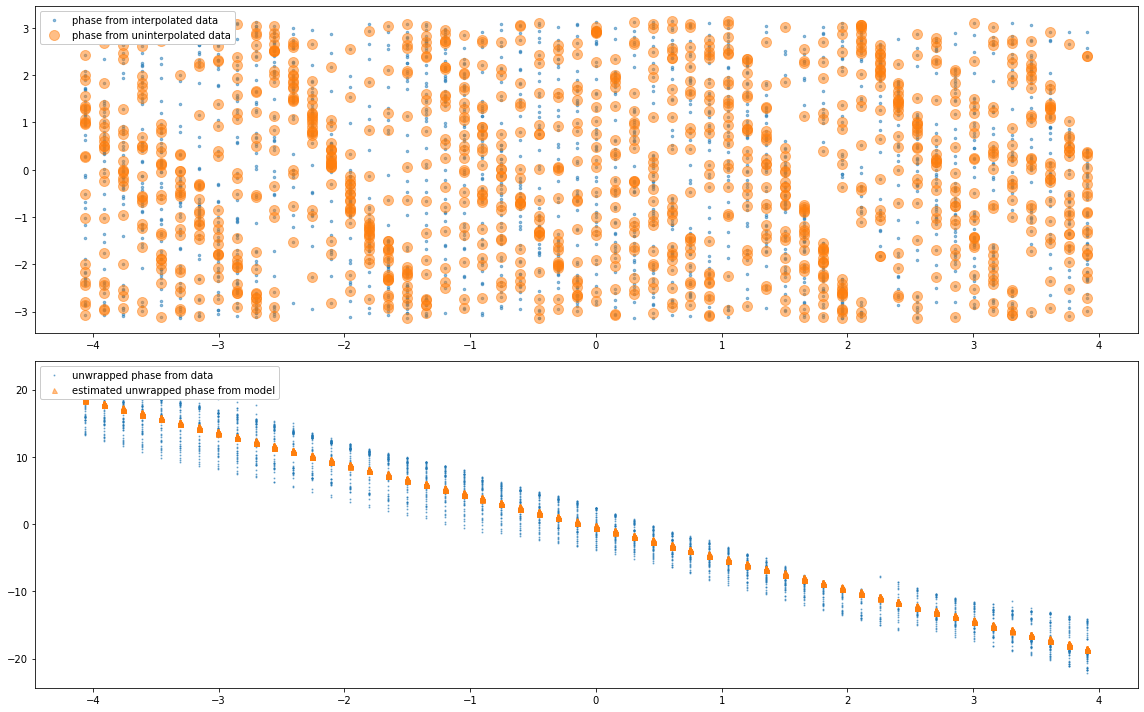

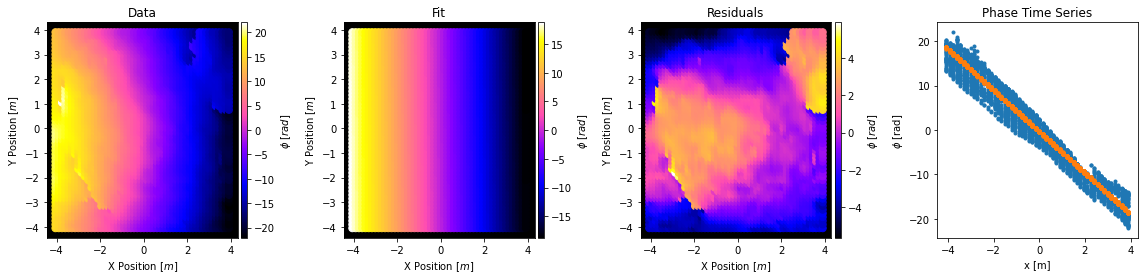

In [20]:
# get unwerapped phase and plot for data and interpolated data
phi_data,phi_data_unwrap,phi_interp,phi_interp_unwrap = get_unwrapped_phase(beam)
plot_unwrapped_phases(beam,phi_data,phi_data_unwrap,phi_interp,phi_interp_unwrap)

# if this looks good, go ahead and make a complex E field from it
cplxEfield2 = get_complexE_remove_geom_phase(beam,find,vplot=True)

In [21]:
# save to a npz file
np.savez("/hirax/NF2FF/cplxEfield_20250611.npz", cplxEfieldNS=cplxEfield1, cplxEfieldEW=cplxEfield2, 
         dx = beam.d0_centers_grid[:,:,0], dy=beam.d1_centers_grid[:,:,0], freq = beam.freq[find])

## This is the by-hand approach from Ana, which is what the above automation is based on

In [ ]:
# Define parameters and files
find = 331 # 340


## These files have already been concatt-ed and pickled
# So you don't have to find the useful times, etc, that was done already
# apparently also it fit the 2D gaussian, so can normalize

pckldir="/hirax/NF2FF/20240308_WLC_NFandFF/products/pickles/"
gfitdir="/hirax/NF2FF/20240308_WLC_NFandFF/products/gfits/"
pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(gfitdir))
print(pcklarr[:])
print(gfitarr[:])


## Start with one of the Far Field flights
### These have obvious fringing and the ability
### to compare the fringe rate with dish/bico spacing

In [ ]:
# Curious what the raw data looks like

with open(pckldir+pcklarr[0], 'rb') as pfile:
    print(pfile)
    concatff=pickle.load(pfile)
t_cut=concatff.inds_on    
print(concatff.V_bgsub.shape) # time, freq, input


chind = 0
plt.scatter(concatff.drone_xyz_per_dish_interp[chind,t_cut,0],
                     concatff.drone_xyz_per_dish_interp[chind,t_cut,1],
                     c=concatff.V_bgsub[t_cut,find,chind],cmap=cm.gnuplot2,norm=LogNorm())
plt.colorbar()
plt.show()

chind = 1
plt.scatter(concatff.drone_xyz_per_dish_interp[chind,t_cut,0],
                     concatff.drone_xyz_per_dish_interp[chind,t_cut,1],
                     c=concatff.V_bgsub[t_cut,find,chind],cmap=cm.gnuplot2,norm=LogNorm())
plt.colorbar()
plt.show()
# channel 0 must be bicolog, 1 must be dish itself

print(concatff.V_cross_bgsub.shape)

In [ ]:
print(concatff.V_cross_bgsub.shape)

plt.scatter(concatff.drone_xyz_per_dish_interp[chind,t_cut,0],
                     concatff.drone_xyz_per_dish_interp[chind,t_cut,1],
                     c=concatff.V_cross_bgsub[t_cut,find,0].real,cmap=cm.gnuplot2)
plt.colorbar()
plt.show()

plt.scatter(concatff.drone_xyz_per_dish_interp[chind,t_cut,0],
                     concatff.drone_xyz_per_dish_interp[chind,t_cut,1],
                     c=concatff.V_cross_bgsub[t_cut,find,0].imag,cmap=cm.gnuplot2)
plt.colorbar()
plt.show()

In [ ]:
# Create a normalized, gridded beam for Flight 1 (Farfield, NS pol):

FFNSbeam=beammap.Beammap(concatlist=[pcklarr[0]],gfitlist=[gfitarr[0]],\
                         d0args=[-40,40,0.45],d1args=[-40,40,0.45],f_index_cc=340,\
                         normalization='Gauss',operation='coadd',
                         pickle_directory="/hirax/20240308_WLC_NFandFF/products/pickles/",\
                         gfit_directory="/hirax/20240308_WLC_NFandFF/products/gfits/",\
                         flightmasterpath="../metadata/20240308_WLC_flights_forscripts.yaml",\
                         vplot=True,include_cross_data=True)


In [ ]:
# Plot at least one of these on my own

chind = 0
print(FFNSbeam.V_LC_operation.shape) # grid, grid, freq, input
plt.pcolormesh(FFNSbeam.d0_centers_grid[:,:,chind],FFNSbeam.d1_centers_grid[:,:,chind],
               FFNSbeam.V_LC_operation[:,:,find,chind].T,cmap=cm.gnuplot2,norm=LogNorm())#,edgecolors='k')
plt.colorbar()
plt.show()

chind = 1
print(FFNSbeam.V_LC_operation.shape) # grid, grid, freq, input
plt.pcolormesh(FFNSbeam.d0_centers_grid[:,:,chind],FFNSbeam.d1_centers_grid[:,:,chind],
               FFNSbeam.V_LC_operation[:,:,find,chind].T,cmap=cm.gnuplot2,norm=LogNorm())#,edgecolors='k')
plt.colorbar()
plt.show()

print(FFNSbeam.V_LC_cross.shape)
chind = 0
print(FFNSbeam.V_LC_operation.shape) # grid, grid, freq, input
plt.pcolormesh(FFNSbeam.d0_centers_grid[:,:,chind],FFNSbeam.d1_centers_grid[:,:,chind],
               FFNSbeam.V_LC_cross[:,:,find,chind,0].real.T,cmap=cm.gnuplot2)#,edgecolors='k')
plt.colorbar()
plt.show()

plt.pcolormesh(FFNSbeam.d0_centers_grid[:,:,chind],FFNSbeam.d1_centers_grid[:,:,chind],
               FFNSbeam.V_LC_cross[:,:,find,chind,0].imag.T,cmap=cm.gnuplot2)#,edgecolors='k')
plt.colorbar()
plt.show()

plt.pcolormesh(FFNSbeam.d0_centers_grid[:,:,chind],FFNSbeam.d1_centers_grid[:,:,chind],
               abs(FFNSbeam.V_LC_cross[:,:,find,chind,0]).T,cmap=cm.gnuplot2)#,edgecolors='k')
plt.colorbar()
plt.show()

plt.pcolormesh(FFNSbeam.d0_centers_grid[:,:,chind],FFNSbeam.d1_centers_grid[:,:,chind],
               np.angle(FFNSbeam.V_LC_cross[:,:,find,chind,0]).T,cmap=cm.gnuplot2)#,edgecolors='k')
plt.colorbar()
plt.show()

In [ ]:
## Call the interpolation function from the beammap class
# this does in fact take a long time

FFNSbeam.complex_interpolation(d0_interp=FFNSbeam.d0_centers[:,0], d1_interp=FFNSbeam.d1_centers[:,0],method='cubic',variogram_model='spherical',outputs=False,Fargs=[340,340])

In [ ]:
## plot the results of the interpolation and find where to cut to eliminate NAN values:

fig,[[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]]=subplots(nrows=2,ncols=4,figsize=(16,9))
ax1.pcolormesh(FFNSbeam.d0_centers_grid[:,:,0],FFNSbeam.d1_centers_grid[:,:,0],FFNSbeam.V_LC_cross.real[:,:,find,0,0])
ax2.pcolormesh(FFNSbeam.d0_centers_grid[:,:,0],FFNSbeam.d1_centers_grid[:,:,0],FFNSbeam.V_LC_cross.imag[:,:,find,0,0])
ax3.pcolormesh(FFNSbeam.d0_centers_grid[:,:,0],FFNSbeam.d1_centers_grid[:,:,0],np.abs(FFNSbeam.V_LC_cross)[:,:,find,0,0])#,norm=LogNorm())
ax4.pcolormesh(FFNSbeam.d0_centers_grid[:,:,0],FFNSbeam.d1_centers_grid[:,:,0],np.angle(FFNSbeam.V_LC_cross)[:,:,find,0,0])

ax5.pcolormesh(FFNSbeam.d0_centers_grid[:,:,0],FFNSbeam.d1_centers_grid[:,:,0],FFNSbeam.beam_linear_interp.real[:,:,find,0])
ax6.pcolormesh(FFNSbeam.d0_centers_grid[:,:,0],FFNSbeam.d1_centers_grid[:,:,0],FFNSbeam.beam_linear_interp.imag[:,:,find,0])
ax7.pcolormesh(FFNSbeam.d0_centers_grid[:,:,0],FFNSbeam.d1_centers_grid[:,:,0],FFNSbeam.beam_linear_interp_amp[:,:,find,0])#,norm=LogNorm())
ax8.pcolormesh(FFNSbeam.d0_centers_grid[:,:,0],FFNSbeam.d1_centers_grid[:,:,0],FFNSbeam.beam_linear_interp_phase[:,:,find,0])

titles=['real','imag','mag','phase','interp_real','interp_imag','interp_mag','interp_phase']
for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]):
    ax.set_title(titles[i]+' @ {} --> {:.2f} MHz'.format(find,FFNSbeam.freq[find]))
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ## Plot the lines where we will do the reassignment/dimension change
    ax.axvline(FFNSbeam.d0_centers_grid[35,0,0])
    ax.axhline(FFNSbeam.d1_centers_grid[0,35,0])
    ax.axvline(FFNSbeam.d0_centers_grid[-35,0,0])
    ax.axhline(FFNSbeam.d1_centers_grid[0,-35,0])
    
tight_layout()

In [ ]:
## This is where we reassign the arrays to a restricted range (inside the lines above)--this is to remove NaNs before interpolating
## Careful not to run this twice, or things will start to break!

#stop # uncomment this after you've run it once
xmin,xmax,ymin,ymax=[35,-35,35,-35]
FFNSbeam.beam_linear_interp=FFNSbeam.beam_linear_interp[xmin:xmax,ymin:ymax]
FFNSbeam.beam_linear_interp_amp=FFNSbeam.beam_linear_interp_amp[xmin:xmax,ymin:ymax]
FFNSbeam.beam_linear_interp_phase=FFNSbeam.beam_linear_interp_phase[xmin:xmax,ymin:ymax]
FFNSbeam.beam_linear_interp_phase_unwrapped=FFNSbeam.beam_linear_interp_phase_unwrapped[xmin:xmax,ymin:ymax]
FFNSbeam.histogram_LC=FFNSbeam.histogram_LC[xmin:xmax,ymin:ymax]
FFNSbeam.V_LC_cross=FFNSbeam.V_LC_cross[xmin:xmax,ymin:ymax]
FFNSbeam.V_LC_mean=FFNSbeam.V_LC_mean[xmin:xmax,ymin:ymax]
FFNSbeam.V_LC_operation=FFNSbeam.V_LC_operation[xmin:xmax,ymin:ymax]
FFNSbeam.V_LC_std=FFNSbeam.V_LC_std[xmin:xmax,ymin:ymax]
FFNSbeam.d0_centers_grid=FFNSbeam.d0_centers_grid[xmin:xmax,ymin:ymax]
FFNSbeam.d0_edges_grid=FFNSbeam.d0_edges_grid[xmin:xmax,ymin:ymax]
FFNSbeam.d1_centers_grid=FFNSbeam.d1_centers_grid[xmin:xmax,ymin:ymax]
FFNSbeam.d1_edges_grid=FFNSbeam.d1_edges_grid[xmin:xmax,ymin:ymax]
    
FFNSbeam.d0_centers=FFNSbeam.d0_centers[xmin:xmax]
FFNSbeam.d0_edges=FFNSbeam.d0_edges[xmin:xmax]
FFNSbeam.d1_centers=FFNSbeam.d1_centers[ymin:ymax]
FFNSbeam.d1_edges=FFNSbeam.d1_edges[ymin:ymax]

In [ ]:
# Perform the phase unwrapping and plot the results, hopefully it appears as a gradient!
## pick a frequency by changing 'find', but be careful to change it in the other places it appears...

fig1,[ax1,ax2,ax3,ax4]=subplots(nrows=1,ncols=4,figsize=(16,4))

phi1=np.angle(FFNSbeam.V_LC_cross[:,:,find,0,0])
phi1unwrap=unwrap2d(phi1)
phi_i=FFNSbeam.beam_linear_interp_phase[:,:,find,0]
phi_iunwrap=unwrap2d(phi_i)
im1=ax1.pcolormesh(FFNSbeam.d0_centers_grid[:,:,0],FFNSbeam.d1_centers_grid[:,:,0],phi1,cmap='gnuplot2')
im2=ax2.pcolormesh(FFNSbeam.d0_centers_grid[:,:,0],FFNSbeam.d1_centers_grid[:,:,0],phi1unwrap,cmap='gnuplot2')
im3=ax3.pcolormesh(FFNSbeam.d0_centers_grid[:,:,0],FFNSbeam.d1_centers_grid[:,:,0],phi_i,cmap='gnuplot2')
im4=ax4.pcolormesh(FFNSbeam.d0_centers_grid[:,:,0],FFNSbeam.d1_centers_grid[:,:,0],phi_iunwrap,cmap='gnuplot2')
images=[im1,im2,im3,im4]
titles=["pcm no interp no unwrap","pcm no interp yes unwrap","pcm yes interp no unwrap","pcm yes interp yes unwrap"]
cbarlabels=["$\phi$","$\phi$","$\phi$","$\phi$"]
for j,ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.set_title(titles[j])
    ax.set_facecolor('k')
    ax.set_xlabel('$x,[m]$')
    ax.set_ylabel('$y, [m]$')
    divider=make_axes_locatable(ax)
    cax=divider.append_axes("right", size="3%", pad=0.05)
    cbar=fig.colorbar(images[j],cax=cax)
    cbar.set_label(cbarlabels[j])
# for ax in [ax2,ax5,ax6]:
#     ax.plot(range(-20,20),range(-20,20),'r-',linewidth=10)
tight_layout()


In [ ]:
## Plot the wrapped and unwrapped phase, and see if a linear regression fits to the data... it should have a slope!

dx=FFNSbeam.d0_centers_grid[:,:,0]
dy=FFNSbeam.d1_centers_grid[:,:,0]
wl=(3.0e8/(FFNSbeam.freq[find]*1e6))
dc=(FFNSbeam.V_LC_cross[:,:,find,0,0]).flatten() # flatten the cross array
dcabs=np.abs(FFNSbeam.V_LC_cross[:,:,find,0,0]).flatten() # abs of the cross

phi1=np.angle(FFNSbeam.V_LC_cross[:,:,find,0,0])
phi1unwrap=unwrap2d(phi1) # unwraps the original data
phi_i=FFNSbeam.beam_linear_interp_phase[:,:,find,0]
phi_iunwrap=unwrap2d(phi_i) # unwraps the interpolated beam

dcang=phi_iunwrap.flatten() # flattens the interpolated beam

dcoords=np.zeros((dx.shape[0]*dx.shape[1],3))
dcoords[:,0]=dx.flatten()
dcoords[:,1]=dy.flatten()
dcoords[:,2]=(100*np.ones((dx.shape[0]*dx.shape[1]))).flatten()
unitvects=dcoords*np.outer(np.nansum((dcoords)**2.0,axis=1)**-0.5,np.ones(3)) # should be the unit vector to the drone


popt=least_squares(Fringe_Fit,x0=np.array([0.0,0.0,0.0,0.0]),args=[unitvects[~np.isnan(dcang)],dcang[~np.isnan(dcang)],wl]).x
# fits dish/ref spacing 
print("(A,B,C)=({:f},{:f},{:f})".format(popt[0],popt[1],popt[2]))
#print("(D,E,F)=({:.3f},{:.3f},{:.3f})".format(popt[3],popt[4],popt[5]))
print("G={:.3f}".format(popt[3]))

fig1,[ax1,ax2]=subplots(nrows=2,ncols=1,figsize=(16,10))
ax1.plot(dcoords[:,0],phi_i.flatten(),'.',alpha=0.5,markersize=5,label='phase from interpolated data')
ax1.plot(dcoords[:,0],phi1.flatten(),'.',alpha=0.5,markersize=20,label='phase from uninterpolated data')
ax1.legend(loc=2,framealpha=1)
ax2.plot(dcoords[:,0],dcang,'.',alpha=0.5,markersize=2,label='unwrapped phase from data')
ax2.plot(dcoords[:,0],Fringe(np.array(popt),unitvects,wl),'^',alpha=0.5,markersize=5,label='estimated unwrapped phase from model')
ax2.legend(loc=2,framealpha=1)
tight_layout()


In [ ]:
plt.pcolormesh(FFNSbeam.d0_centers_grid[:,:,0],FFNSbeam.d1_centers_grid[:,:,0],phi1,cmap='gnuplot2')
plt.title('Phase Data')
plt.xlabel('X position [m]')
plt.xlabel('Y position [m]')
plt.colorbar()
plt.show()

plt.pcolormesh(FFNSbeam.d0_centers_grid[:,:,0],FFNSbeam.d1_centers_grid[:,:,0],phi_i,cmap='gnuplot2')
plt.title('Interpolated phase Data')
plt.xlabel('X position [m]')
plt.xlabel('Y position [m]')
plt.colorbar()
plt.show()

plt.pcolormesh(FFNSbeam.d0_centers_grid[:,:,0],FFNSbeam.d1_centers_grid[:,:,0],phi_iunwrap,cmap='gnuplot2')
plt.title('Unwrapped interpolated phase Data')
plt.xlabel('X position [m]')
plt.xlabel('Y position [m]')
plt.colorbar()
plt.show()

plt.scatter(dx,dy,s=50,c=Fringe(popt,unitvects,wl),cmap='gnuplot2') # the fringe fit
plt.title('Fit to phase Data')
plt.xlabel('X position [m]')
plt.xlabel('Y position [m]')
plt.colorbar()
plt.show()

plt.scatter(dx,dy,s=50,c=(dcang-Fringe(popt,unitvects,wl)),cmap='gnuplot2')
plt.title('Residuals')
plt.xlabel('X position [m]')
plt.xlabel('Y position [m]')
plt.colorbar()
plt.show()


plt.plot(dcoords[:,0],dcang,'.')
plt.plot(dcoords[:,0],Fringe(np.array(popt),unitvects,wl),'.')
plt.title('Phase time series')
plt.xlabel('X position [m]')
plt.xlabel('Phase')
plt.show()

In [ ]:
plt.pcolormesh(dx, dy, phi_iunwrap[:,:],cmap='gnuplot2')
plt.colorbar()
plt.show()

plt.pcolormesh(dx, dy, Fringe(popt,unitvects,wl).reshape(dx.shape),cmap='gnuplot2')
plt.colorbar()
plt.show()

plt.pcolormesh(dx, dy, phi_iunwrap[:,:] - Fringe(popt,unitvects,wl).reshape(dx.shape),cmap='gnuplot2')
plt.colorbar()
plt.show()


In [ ]:
# here, we put the phase and the amplitude together into a complex electric field

ampl=FFNSbeam.beam_linear_interp_amp[:,:,find,0]
phase=phi_iunwrap[:,:]-Fringe(popt,unitvects,wl).reshape(dx.shape) # this should be the residual phase: data - geom. fit
cplxEfieldNSFF=ampl*np.exp(1.0j*phase)

In [ ]:
plt.pcolormesh(dx, dy, FFNSbeam.beam_linear_interp_amp[:,:,find,0], norm=LogNorm(),cmap='gnuplot2')
plt.colorbar()
plt.xlabel('X [m]')
plt.xlabel('Y [m]')
plt.title('Cross-Corr Amplitude (interp)')
plt.show()

plt.pcolormesh(dx, dy, phase, cmap='gnuplot2',vmin=-np.pi, vmax=np.pi)
plt.colorbar()
plt.xlabel('X [m]')
plt.xlabel('Y [m]')
plt.title('Phase (interp)')
plt.show()

plt.pcolormesh(dx, dy, ampl, norm=LogNorm(), cmap='gnuplot2')
plt.colorbar()
plt.xlabel('X [m]')
plt.xlabel('Y [m]')
plt.title('AUT amplitude')
plt.show()

## Now to try a Near-field flight

In [ ]:
# NEARFIELD FLIGHT 1: 
#   NS Polarization
#   18m Altitude

## To prepare data for the NF2FF code, we need to determine the electric field in both polarizations:
## NF File 1: ch0=Bicolog, ch1=Telescope_Y_NSpol --> ## 'FLY781.csv' - Altitude ~18m, Yaw ~0deg --> NFNS18
## NF File 2: ch0=Telescope_X_EWpol, ch1=Bicolog
    ## 'FLY782.csv' - Altitude ~18m, Yaw ~90deg  --> NFEW18
    ## 'FLY783.csv' - Altitude ~20m, Yaw ~90deg  --> NFEW20   
    
print(pcklarr)

In [ ]:
# Create the beammap class for NF Flight 1:

NFNSbeam=beammap.Beammap(concatlist=[pcklarr[1]],gfitlist=[gfitarr[1]],\
                         d0args=[-10,10,0.15],d1args=[-10,10,0.15],f_index_cc=360,\
                         normalization='Gauss',operation='coadd',
                         pickle_directory="/hirax/20240308_WLC_NFandFF/products/pickles/",\
                         gfit_directory="/hirax/20240308_WLC_NFandFF/products/gfits/",\
                         flightmasterpath="../metadata/20240308_WLC_flights_forscripts.yaml",\
                         vplot=True,include_cross_data=True)


In [ ]:
# Plot at least one of these on my own

chind = 0
print(NFNSbeam.V_LC_operation.shape) # grid, grid, freq, input
plt.pcolormesh(NFNSbeam.d0_centers_grid[:,:,chind],NFNSbeam.d1_centers_grid[:,:,chind],
               NFNSbeam.V_LC_operation[:,:,find,chind].T,cmap=cm.gnuplot2,norm=LogNorm())#,edgecolors='k')
plt.colorbar()
plt.show()

chind = 1
print(NFNSbeam.V_LC_operation.shape) # grid, grid, freq, input
plt.pcolormesh(NFNSbeam.d0_centers_grid[:,:,chind],NFNSbeam.d1_centers_grid[:,:,chind],
               NFNSbeam.V_LC_operation[:,:,find,chind].T,cmap=cm.gnuplot2,norm=LogNorm())#,edgecolors='k')
plt.colorbar()
plt.show()

print(NFNSbeam.V_LC_cross.shape)
chind = 0
print(NFNSbeam.V_LC_operation.shape) # grid, grid, freq, input
plt.pcolormesh(NFNSbeam.d0_centers_grid[:,:,chind],NFNSbeam.d1_centers_grid[:,:,chind],
               NFNSbeam.V_LC_cross[:,:,find,chind,0].real.T,cmap=cm.gnuplot2)#,edgecolors='k')
plt.colorbar()
plt.show()

plt.pcolormesh(NFNSbeam.d0_centers_grid[:,:,chind],NFNSbeam.d1_centers_grid[:,:,chind],
               NFNSbeam.V_LC_cross[:,:,find,chind,0].imag.T,cmap=cm.gnuplot2)#,edgecolors='k')
plt.colorbar()
plt.show()

plt.pcolormesh(NFNSbeam.d0_centers_grid[:,:,chind],NFNSbeam.d1_centers_grid[:,:,chind],
               abs(NFNSbeam.V_LC_cross[:,:,find,chind,0]).T,cmap=cm.gnuplot2)#,edgecolors='k')
plt.colorbar()
plt.show()

plt.pcolormesh(NFNSbeam.d0_centers_grid[:,:,chind],NFNSbeam.d1_centers_grid[:,:,chind],
               np.angle(NFNSbeam.V_LC_cross[:,:,find,chind,0]).T,cmap=cm.gnuplot2)#,edgecolors='k')
plt.colorbar()
plt.show()

In [ ]:
NFNSbeam.complex_interpolation(d0_interp=NFNSbeam.d0_centers[:,0], d1_interp=NFNSbeam.d1_centers[:,0],method='cubic',variogram_model='spherical',outputs=False,Fargs=[340,340])

In [ ]:
fig,[[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]]=subplots(nrows=2,ncols=4,figsize=(16,9))
#find=250
ax1.pcolormesh(NFNSbeam.d0_centers_grid[:,:,0],NFNSbeam.d1_centers_grid[:,:,0],NFNSbeam.V_LC_cross.real[:,:,find,0,0])
ax2.pcolormesh(NFNSbeam.d0_centers_grid[:,:,0],NFNSbeam.d1_centers_grid[:,:,0],NFNSbeam.V_LC_cross.imag[:,:,find,0,0])
ax3.pcolormesh(NFNSbeam.d0_centers_grid[:,:,0],NFNSbeam.d1_centers_grid[:,:,0],np.abs(NFNSbeam.V_LC_cross)[:,:,find,0,0])#,norm=LogNorm())
ax4.pcolormesh(NFNSbeam.d0_centers_grid[:,:,0],NFNSbeam.d1_centers_grid[:,:,0],np.angle(NFNSbeam.V_LC_cross)[:,:,find,0,0])

ax5.pcolormesh(NFNSbeam.d0_centers_grid[:,:,0],NFNSbeam.d1_centers_grid[:,:,0],NFNSbeam.beam_linear_interp.real[:,:,find,0])
ax6.pcolormesh(NFNSbeam.d0_centers_grid[:,:,0],NFNSbeam.d1_centers_grid[:,:,0],NFNSbeam.beam_linear_interp.imag[:,:,find,0])
ax7.pcolormesh(NFNSbeam.d0_centers_grid[:,:,0],NFNSbeam.d1_centers_grid[:,:,0],NFNSbeam.beam_linear_interp_amp[:,:,find,0])#,norm=LogNorm())
ax8.pcolormesh(NFNSbeam.d0_centers_grid[:,:,0],NFNSbeam.d1_centers_grid[:,:,0],NFNSbeam.beam_linear_interp_phase[:,:,find,0])

titles=['real','imag','mag','phase','interp_real','interp_imag','interp_mag','interp_phase']
for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]):
    ax.set_title(titles[i]+' @ {} --> {:.2f} MHz'.format(find,NFNSbeam.freq[find]))
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.axvline(NFNSbeam.d0_centers_grid[40,0,0])
    ax.axhline(NFNSbeam.d1_centers_grid[0,40,0])
    ax.axvline(NFNSbeam.d0_centers_grid[-40,0,0])
    ax.axhline(NFNSbeam.d1_centers_grid[0,-40,0])
tight_layout()

In [ ]:
#stop
xmin,xmax,ymin,ymax=[40,-40,40,-40]
NFNSbeam.beam_linear_interp=NFNSbeam.beam_linear_interp[xmin:xmax,ymin:ymax]
NFNSbeam.beam_linear_interp_amp=NFNSbeam.beam_linear_interp_amp[xmin:xmax,ymin:ymax]
NFNSbeam.beam_linear_interp_phase=NFNSbeam.beam_linear_interp_phase[xmin:xmax,ymin:ymax]
NFNSbeam.beam_linear_interp_phase_unwrapped=NFNSbeam.beam_linear_interp_phase_unwrapped[xmin:xmax,ymin:ymax]
NFNSbeam.histogram_LC=NFNSbeam.histogram_LC[xmin:xmax,ymin:ymax]
NFNSbeam.V_LC_cross=NFNSbeam.V_LC_cross[xmin:xmax,ymin:ymax]
NFNSbeam.V_LC_mean=NFNSbeam.V_LC_mean[xmin:xmax,ymin:ymax]
NFNSbeam.V_LC_operation=NFNSbeam.V_LC_operation[xmin:xmax,ymin:ymax]
NFNSbeam.V_LC_std=NFNSbeam.V_LC_std[xmin:xmax,ymin:ymax]
NFNSbeam.d0_centers_grid=NFNSbeam.d0_centers_grid[xmin:xmax,ymin:ymax]
NFNSbeam.d0_edges_grid=NFNSbeam.d0_edges_grid[xmin:xmax,ymin:ymax]
NFNSbeam.d1_centers_grid=NFNSbeam.d1_centers_grid[xmin:xmax,ymin:ymax]
NFNSbeam.d1_edges_grid=NFNSbeam.d1_edges_grid[xmin:xmax,ymin:ymax]
    
    
NFNSbeam.d0_centers=NFNSbeam.d0_centers[xmin:xmax]
NFNSbeam.d0_edges=NFNSbeam.d0_edges[xmin:xmax]
NFNSbeam.d1_centers=NFNSbeam.d1_centers[ymin:ymax]
NFNSbeam.d1_edges=NFNSbeam.d1_edges[ymin:ymax]

In [ ]:
fig1,[ax1,ax2,ax3,ax4]=subplots(nrows=1,ncols=4,figsize=(16,4))
phi1NS=np.angle(NFNSbeam.V_LC_cross[:,:,find,0,0])
phiunwrapNS=unwrap2d(phi1NS,wrap_args=(False,True))
phi_iNS=NFNSbeam.beam_linear_interp_phase[:,:,find,0]
phi_iunwrapNS=unwrap2d(phi_iNS,wrap_args=(False,True))

im1=ax1.pcolormesh(NFNSbeam.d0_centers_grid[:,:,0],NFNSbeam.d1_centers_grid[:,:,0],phi1NS,cmap='gnuplot2')
im2=ax2.pcolormesh(NFNSbeam.d0_centers_grid[:,:,0],NFNSbeam.d1_centers_grid[:,:,0],phiunwrapNS,cmap='gnuplot2')
im3=ax3.pcolormesh(NFNSbeam.d0_centers_grid[:,:,0],NFNSbeam.d1_centers_grid[:,:,0],phi_iNS,cmap='gnuplot2')
im4=ax4.pcolormesh(NFNSbeam.d0_centers_grid[:,:,0],NFNSbeam.d1_centers_grid[:,:,0],phi_iunwrapNS,cmap='gnuplot2')
images=[im1,im2,im3,im4]
titles=["pcm no interp no unwrap","pcm no interp yes unwrap","pcm yes interp no unwrap","pcm yes interp yes unwrap"]
cbarlabels=["$\phi$","$\phi$","$\phi$","$\phi$"]
for j,ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.set_title(titles[j])
    ax.set_facecolor('k')
    ax.set_xlabel('$x,[m]$')
    ax.set_ylabel('$y, [m]$')
    divider=make_axes_locatable(ax)
    cax=divider.append_axes("right", size="3%", pad=0.05)
    cbar=fig.colorbar(images[j],cax=cax)
    cbar.set_label(cbarlabels[j])
# for ax in [ax2,ax5,ax6]:
#     ax.plot(range(-20,20),range(-20,20),'r-',linewidth=10)
tight_layout()


In [ ]:

dxNS=NFNSbeam.d0_centers_grid[:,:,0]
dyNS=NFNSbeam.d1_centers_grid[:,:,0]
wlNS=(3.0e8/(NFNSbeam.freq[find]*1e6)) # keep this in m if you don't want everything to break!!
dcNS=(NFNSbeam.V_LC_cross[:,:,find,0,0]).flatten()
dcabsNS=np.abs(NFNSbeam.V_LC_cross[:,:,find,0,0]).flatten()

phi1NS=np.angle(NFNSbeam.V_LC_cross[:,:,find,0,0])
phi1unwrapNS=unwrap2d(phi1NS)
phi_iNS=NFNSbeam.beam_linear_interp_phase[:,:,find,0]
phi_iunwrapNS=unwrap2d(phi_iNS)

dcangNS=phi_iunwrapNS.flatten()

dcoordsNS=np.zeros((dxNS.shape[0]*dxNS.shape[1],3))
dcoordsNS[:,0]=dxNS.flatten()
dcoordsNS[:,1]=dyNS.flatten()
dcoordsNS[:,2]=(100*np.ones((dxNS.shape[0]*dxNS.shape[1]))).flatten()
unitvectsNS=dcoordsNS*np.outer(np.nansum((dcoordsNS)**2.0,axis=1)**-0.5,np.ones(3))

poptNS=least_squares(Fringe_Fit,x0=np.array([0.0,0.0,0.0,0.0]),args=[unitvectsNS[~np.isnan(dcangNS)],dcangNS[~np.isnan(dcangNS)],wlNS]).x
print("(A,B,C)=({:f},{:f},{:f})".format(poptNS[0],poptNS[1],poptNS[2]))
# print("(D,E,F)=({:.3f},{:.3f},{:.3f})".format(popt[3],popt[4],popt[5]))
print("G={:.3f}".format(poptNS[3]))

fig1,[ax1,ax2]=subplots(nrows=2,ncols=1,figsize=(16,10))
ax1.plot(dcoordsNS[:,0],phi_iNS.flatten(),'.',alpha=0.5,markersize=5,label='phase from interpolated data')
ax1.plot(dcoordsNS[:,0],phi1NS.flatten(),'.',alpha=0.5,markersize=20,label='phase from uninterpolated data')
ax1.legend(loc=2,framealpha=1)
ax2.plot(dcoordsNS[:,0],dcangNS,'.',alpha=0.5,markersize=2,label='unwrapped phase from data')
ax2.plot(dcoordsNS[:,0],Fringe(np.array(poptNS),unitvectsNS,wlNS),'^',alpha=0.5,markersize=5,label='estimated unwrapped phase from model')
ax2.legend(loc=2,framealpha=1)
tight_layout()

In [ ]:
plt.pcolormesh(NFNSbeam.d0_centers_grid[:,:,0],NFNSbeam.d1_centers_grid[:,:,0],phi1NS,cmap='gnuplot2')
plt.title('Phase Data')
plt.xlabel('X position [m]')
plt.xlabel('Y position [m]')
plt.colorbar()
plt.show()

plt.pcolormesh(NFNSbeam.d0_centers_grid[:,:,0],NFNSbeam.d1_centers_grid[:,:,0],phi_iNS,cmap='gnuplot2')
plt.title('Interpolated phase Data')
plt.xlabel('X position [m]')
plt.xlabel('Y position [m]')
plt.colorbar()
plt.show()

plt.pcolormesh(NFNSbeam.d0_centers_grid[:,:,0],NFNSbeam.d1_centers_grid[:,:,0],phi_iunwrapNS,cmap='gnuplot2')
plt.title('Unwrapped interpolated phase Data')
plt.xlabel('X position [m]')
plt.xlabel('Y position [m]')
plt.colorbar()
plt.show()

plt.scatter(dxNS,dyNS,s=50,c=Fringe(poptNS,unitvectsNS,wl),cmap='gnuplot2') # the fringe fit
plt.title('Fit to phase Data')
plt.xlabel('X position [m]')
plt.xlabel('Y position [m]')
plt.colorbar()
plt.show()

plt.scatter(dxNS,dyNS,s=50,c=(dcangNS-Fringe(poptNS,unitvectsNS,wl)),cmap='gnuplot2')
plt.title('Residuals')
plt.xlabel('X position [m]')
plt.xlabel('Y position [m]')
plt.colorbar()
plt.show()


plt.plot(dcoordsNS[:,0],dcangNS,'.')
plt.plot(dcoordsNS[:,0],Fringe(np.array(poptNS),unitvectsNS,wl),'.')
plt.title('Phase time series')
plt.xlabel('X position [m]')
plt.xlabel('Phase')
plt.show()

In [ ]:
amplNS=NFNSbeam.beam_linear_interp_amp[:,:,find,0]
phaseNS=phi_iunwrapNS[:,:]-Fringe(poptNS,unitvectsNS,wl).reshape(dxNS.shape) # this should be the residual phase: data - geom. fit
cplxEfieldNS=amplNS*np.exp(1.0j*phaseNS)

In [ ]:
plt.pcolormesh(dxNS, dyNS, NFNSbeam.beam_linear_interp_amp[:,:,find,0], norm=LogNorm(),cmap='gnuplot2')
plt.colorbar()
plt.xlabel('X [m]')
plt.xlabel('Y [m]')
plt.title('Cross-Corr Amplitude (interp)')
plt.show()

plt.pcolormesh(dxNS, dyNS, phaseNS, cmap='gnuplot2',vmin=-np.pi, vmax=np.pi)
plt.colorbar()
plt.xlabel('X [m]')
plt.xlabel('Y [m]')
plt.title('Phase (interp)')
plt.show()

plt.pcolormesh(dxNS, dyNS, amplNS, norm=LogNorm(), cmap='gnuplot2')
plt.colorbar()
plt.xlabel('X [m]')
plt.xlabel('Y [m]')
plt.title('AUT amplitude')
plt.show()

In [ ]:
fig,[[ax1,ax2],[ax3,ax4],[ax5,ax6]]=subplots(nrows=3,ncols=2,figsize=(10,15),sharex=True,sharey=True)


im1=ax1.pcolormesh(dxNS, dyNS, amplNS, norm=LogNorm(), cmap='gnuplot2')
im4=ax2.pcolormesh(dxNS, dyNS, phaseNS, cmap='gnuplot2')
im5=ax3.pcolormesh(dxNS, dyNS, np.real(cplxEfieldNS), cmap='gnuplot2')
im6=ax4.pcolormesh(dxNS, dyNS, np.imag(cplxEfieldNS), cmap='gnuplot2')
im7=ax5.pcolormesh(dxNS, dyNS, np.abs(cplxEfieldNS), cmap = 'gnuplot2', norm=LogNorm())
im8=ax6.pcolormesh(dxNS, dyNS, np.angle(cplxEfieldNS), cmap = 'gnuplot2')


images=[im1,im2,im3,im4,im5,im6]
cbars=['[$ADU^2$]','$\phi$ [$rad$]','[$ADU^2$]','$\phi$ [$rad$]','[$ADU^2$]','[$ADU^2$]','[$ADU^2$]','$\phi$ [$rad$]']
titles=["AUT Amplitude","Cross-Corr Phase (interp)","AUT Amplitude (interp)","AUT Phase (geom. corrected)","Re(AUT E-field)","Im(AUT E-field)","Abs(AUT E-field)","Angle(AUT E-field)"]
for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):
    ax.set_facecolor("k")
    ax.set_xlabel('X Position $[m]$')
    ax.set_ylabel('Y Position $[m]$')
    divider=make_axes_locatable(ax)
    cax=divider.append_axes("right", size="3%", pad=0.05)
    cbar=fig1.colorbar(images[i],cax=cax)
    cbar.set_label(cbars[i])
for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):
    ax.set_title(titles[i])
ax4.set_xlabel("x [m]")
ax4.set_ylabel("$\phi$ [rad]")
tight_layout()

In [ ]:
## To prepare data for the NF2FF code, we need to determine the electric field in both polarizations:
## NF File 1: ch0=Bicolog, ch1=Telescope_Y_NSpol --> ## 'FLY781.csv' - Altitude ~18m, Yaw ~0deg --> NFNS18
## NF File 2: ch0=Telescope_X_EWpol, ch1=Bicolog
    ## 'FLY782.csv' - Altitude ~18m, Yaw ~90deg  --> NFEW18
    ## 'FLY783.csv' - Altitude ~20m, Yaw ~90deg  --> NFEW20 

In [ ]:
## NF File 2: ch0=Telescope_X_EWpol, ch1=Bicolog

NFEWbeam=beammap.Beammap(concatlist=[pcklarr[2]],gfitlist=[gfitarr[2]],d0args=[-10,10,0.15],d1args=[-10,10,0.15],f_index_cc=360,normalization='Gauss',operation='coadd',
                         pickle_directory="/hirax/20240308_WLC_NFandFF/products/pickles/",\
                         gfit_directory="/hirax/20240308_WLC_NFandFF/products/gfits/",\
                         flightmasterpath="../metadata/20240308_WLC_flights_forscripts.yaml",vplot=True,include_cross_data=True)


In [ ]:
NFEWbeam.complex_interpolation(d0_interp=NFEWbeam.d0_centers[:,0], d1_interp=NFEWbeam.d1_centers[:,0],method='cubic',variogram_model='spherical',outputs=False,Fargs=[340,340])

In [ ]:
## plot the results of the interpolation and find where to cut to eliminate NAN values:

fig,[[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]]=subplots(nrows=2,ncols=4,figsize=(16,9))
ax1.pcolormesh(NFEWbeam.d0_centers_grid[:,:,0],NFEWbeam.d1_centers_grid[:,:,0],NFEWbeam.V_LC_cross.real[:,:,find,0,0])
ax2.pcolormesh(NFEWbeam.d0_centers_grid[:,:,0],NFEWbeam.d1_centers_grid[:,:,0],NFEWbeam.V_LC_cross.imag[:,:,find,0,0])
ax3.pcolormesh(NFEWbeam.d0_centers_grid[:,:,0],NFEWbeam.d1_centers_grid[:,:,0],np.abs(NFEWbeam.V_LC_cross)[:,:,find,0,0])#,norm=LogNorm())
ax4.pcolormesh(NFEWbeam.d0_centers_grid[:,:,0],NFEWbeam.d1_centers_grid[:,:,0],np.angle(NFEWbeam.V_LC_cross)[:,:,find,0,0])

ax5.pcolormesh(NFEWbeam.d0_centers_grid[:,:,0],NFEWbeam.d1_centers_grid[:,:,0],NFEWbeam.beam_linear_interp.real[:,:,find,0])
ax6.pcolormesh(NFEWbeam.d0_centers_grid[:,:,0],NFEWbeam.d1_centers_grid[:,:,0],NFEWbeam.beam_linear_interp.imag[:,:,find,0])
ax7.pcolormesh(NFEWbeam.d0_centers_grid[:,:,0],NFEWbeam.d1_centers_grid[:,:,0],NFEWbeam.beam_linear_interp_amp[:,:,find,0])#,norm=LogNorm())
ax8.pcolormesh(NFEWbeam.d0_centers_grid[:,:,0],NFEWbeam.d1_centers_grid[:,:,0],NFEWbeam.beam_linear_interp_phase[:,:,find,0])

titles=['real','imag','mag','phase','interp_real','interp_imag','interp_mag','interp_phase']
for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]):
    ax.set_title(titles[i]+' @ {} --> {:.2f} MHz'.format(find,NFEWbeam.freq[find]))
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.axvline(NFEWbeam.d0_centers_grid[40,0,0])
    ax.axhline(NFEWbeam.d1_centers_grid[0,40,0])
    ax.axvline(NFEWbeam.d0_centers_grid[-40,0,0])
    ax.axhline(NFEWbeam.d1_centers_grid[0,-40,0])
tight_layout()

In [ ]:
NFEWbeam.beam_linear_interp_amp.shape

In [ ]:
# cropping to a square and removing NaNs
#stop
xmin,xmax,ymin,ymax=[40,-40,40,-40]
NFEWbeam.beam_linear_interp=NFEWbeam.beam_linear_interp[xmin:xmax,ymin:ymax]
NFEWbeam.beam_linear_interp_amp=NFEWbeam.beam_linear_interp_amp[xmin:xmax,ymin:ymax]
NFEWbeam.beam_linear_interp_phase=NFEWbeam.beam_linear_interp_phase[xmin:xmax,ymin:ymax]
NFEWbeam.beam_linear_interp_phase_unwrapped=NFEWbeam.beam_linear_interp_phase_unwrapped[xmin:xmax,ymin:ymax]
NFEWbeam.histogram_LC=NFEWbeam.histogram_LC[xmin:xmax,ymin:ymax]
NFEWbeam.V_LC_cross=NFEWbeam.V_LC_cross[xmin:xmax,ymin:ymax]
NFEWbeam.V_LC_mean=NFEWbeam.V_LC_mean[xmin:xmax,ymin:ymax]
NFEWbeam.V_LC_operation=NFEWbeam.V_LC_operation[xmin:xmax,ymin:ymax]
NFEWbeam.V_LC_std=NFEWbeam.V_LC_std[xmin:xmax,ymin:ymax]
NFEWbeam.d0_centers_grid=NFEWbeam.d0_centers_grid[xmin:xmax,ymin:ymax]
NFEWbeam.d0_edges_grid=NFEWbeam.d0_edges_grid[xmin:xmax,ymin:ymax]
NFEWbeam.d1_centers_grid=NFEWbeam.d1_centers_grid[xmin:xmax,ymin:ymax]
NFEWbeam.d1_edges_grid=NFEWbeam.d1_edges_grid[xmin:xmax,ymin:ymax]
    
    
NFEWbeam.d0_centers=NFEWbeam.d0_centers[xmin:xmax]
NFEWbeam.d0_edges=NFEWbeam.d0_edges[xmin:xmax]
NFEWbeam.d1_centers=NFEWbeam.d1_centers[ymin:ymax]
NFEWbeam.d1_edges=NFEWbeam.d1_edges[ymin:ymax]

In [ ]:
NFEWbeam.beam_linear_interp_amp.shape

In [ ]:
fig1,[ax1,ax2,ax3,ax4]=subplots(nrows=1,ncols=4,figsize=(16,4))

phi1=np.angle(NFEWbeam.V_LC_cross[:,:,find,0,0])
phiunwrap=unwrap2d(phi1,wrap_args=(False,True))
phi_i=NFEWbeam.beam_linear_interp_phase[:,:,find,0]
phi_iunwrap=unwrap2d(phi_i,wrap_args=(False,True))

im1=ax1.pcolormesh(NFEWbeam.d0_centers_grid[:,:,0],NFEWbeam.d1_centers_grid[:,:,0],phi1,cmap='gnuplot2')
im2=ax2.pcolormesh(NFEWbeam.d0_centers_grid[:,:,0],NFEWbeam.d1_centers_grid[:,:,0],phiunwrap,cmap='gnuplot2')
im3=ax3.pcolormesh(NFEWbeam.d0_centers_grid[:,:,0],NFEWbeam.d1_centers_grid[:,:,0],phi_i,cmap='gnuplot2')
im4=ax4.pcolormesh(NFEWbeam.d0_centers_grid[:,:,0],NFEWbeam.d1_centers_grid[:,:,0],phi_iunwrap,cmap='gnuplot2')
images=[im1,im2,im3,im4]
titles=["pcm no interp no unwrap","pcm no interp yes unwrap","pcm yes interp no unwrap","pcm yes interp yes unwrap"]
cbarlabels=["$\phi$","$\phi$","$\phi$","$\phi$"]
for j,ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.set_title(titles[j])
    ax.set_facecolor('k')
    ax.set_xlabel('$x,[m]$')
    ax.set_ylabel('$y, [m]$')
    divider=make_axes_locatable(ax)
    cax=divider.append_axes("right", size="3%", pad=0.05)
    cbar=fig.colorbar(images[j],cax=cax)
    cbar.set_label(cbarlabels[j])
# for ax in [ax2,ax5,ax6]:
#     ax.plot(range(-20,20),range(-20,20),'r-',linewidth=10)
tight_layout()


In [ ]:

dx=NFEWbeam.d0_centers_grid[:,:,0]
dy=NFEWbeam.d1_centers_grid[:,:,1]
wl=(3.0e8/(NFEWbeam.freq[find]/1e-6))
dc=(NFEWbeam.V_LC_cross[:,:,find,0,0]).flatten()
dcabs=np.abs(NFEWbeam.V_LC_cross[:,:,find,0,0]).flatten()
dcang=phi_iunwrap.flatten()

phi1=np.angle(NFEWbeam.V_LC_cross[:,:,find,0,0])
phi1unwrap=unwrap2d(phi1)
phi_i=NFEWbeam.beam_linear_interp_phase[:,:,find,0]
phi_iunwrap=unwrap2d(phi_i)

dcang=phi_iunwrap.flatten()

dcoords=np.zeros((dx.shape[0]*dx.shape[1],3))
dcoords[:,0]=dx.flatten()
dcoords[:,1]=dy.flatten()
dcoords[:,2]=(100*np.ones((dx.shape[0]*dx.shape[1]))).flatten()
unitvects=dcoords*np.outer(np.nansum((dcoords)**2.0,axis=1)**-0.5,np.ones(3))

popt=least_squares(Fringe_Fit,x0=np.array([0.0,0.0,0.0,0.0]),args=[unitvects[~np.isnan(dcang)],dcang[~np.isnan(dcang)],wl]).x
print("(A,B,C)=({:f},{:f},{:f})".format(popt[0],popt[1],popt[2]))
# print("(D,E,F)=({:.3f},{:.3f},{:.3f})".format(popt[3],popt[4],popt[5]))
print("G={:.3f}".format(popt[3]))

fig1,[ax1,ax2]=subplots(nrows=2,ncols=1,figsize=(16,10))
ax1.plot(dcoords[:,0],phi_i.flatten(),'.',alpha=0.5,markersize=5,label='phase from interpolated data')
ax1.plot(dcoords[:,0],phi1.flatten(),'.',alpha=0.5,markersize=20,label='phase from uninterpolated data')
ax1.legend(loc=2,framealpha=1)
ax2.plot(dcoords[:,0],dcang,'.',alpha=0.5,markersize=2,label='unwrapped phase from data')
ax2.plot(dcoords[:,0],Fringe(np.array(popt),unitvects,wl),'^',alpha=0.5,markersize=5,label='estimated unwrapped phase from model')
ax2.legend(loc=2,framealpha=1)
tight_layout()


In [ ]:
fig1,[ax1,ax2,ax3,ax4]=subplots(nrows=1,ncols=4,figsize=(16,4))
im1=ax1.scatter(dx,dy,s=50,c=dcang,cmap='gnuplot2')
im2=ax2.scatter(dx,dy,s=50,c=Fringe(popt,unitvects,wl),cmap='gnuplot2')
im3=ax3.scatter(dx,dy,s=50,c=(dcang-Fringe(popt,unitvects,wl)),cmap='gnuplot2')
ax4.plot(dcoords[:,0],dcang,'.')
ax4.plot(dcoords[:,0],Fringe(np.array(popt),unitvects,wl),'.')
images=[im1,im2,im3]
cbars=['$\phi$ [$rad$]','$\phi$ [$rad$]','$\phi$ [$rad$]']
titles=["Data","Fit","Residuals","Phase Time Series"]
for i,ax in enumerate([ax1,ax2,ax3]):
    ax.set_facecolor("k")
    ax.set_xlabel('X Position $[m]$')
    ax.set_ylabel('Y Position $[m]$')
    divider=make_axes_locatable(ax)
    cax=divider.append_axes("right", size="3%", pad=0.05)
    cbar=fig1.colorbar(images[i],cax=cax)
    cbar.set_label(cbars[i])
for i,ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.set_title(titles[i])
ax4.set_xlabel("x [m]")
ax4.set_ylabel("$\phi$ [rad]")
tight_layout()


In [ ]:
# making the complex E-fields to export to the npz

#wl=(3.0e10/(NFEWbeam.freq[find]/1e-6))
#ampl=NFEWbeam.V_LC_mean[:,:,find,0,0]
#phase=fringedata[:,:,zez]-Fringe(fringepopt[zez],dcoords,wl).reshape(dx.shape)
#phasefactor=np.e**(1.0j*phase)
#cplxEfieldEW=ampl*phasefactor



ampl=NFEWbeam.beam_linear_interp_amp[:,:,find,0]
phase=phi_iunwrap[:,:]-Fringe(popt,unitvects,wl).reshape(dx.shape) # this should be the residual phase: data - geom. fit
cplxEfieldEW=ampl*np.exp(1.0j*phaseNS)


In [ ]:
fig,[[ax1,ax2],[ax3,ax4],[ax5,ax6]]=subplots(nrows=3,ncols=2,figsize=(10,15),sharex=True,sharey=True)


im1=ax1.pcolormesh(dx, dy, ampl, norm=LogNorm(), cmap='gnuplot2')
im2=ax2.pcolormesh(dx, dy, phase, cmap='gnuplot2')
im3=ax3.pcolormesh(dx, dy, np.real(cplxEfieldEW), cmap='gnuplot2')
im4=ax4.pcolormesh(dx, dy, np.imag(cplxEfieldEW), cmap='gnuplot2')
im5=ax5.pcolormesh(dx, dy, np.abs(cplxEfieldEW), cmap = 'gnuplot2', norm=LogNorm())
im6=ax6.pcolormesh(dx, dy, np.angle(cplxEfieldEW), cmap = 'gnuplot2')


images=[im1,im2,im3,im4,im5,im6]
cbars=['[$ADU^2$]','$\phi$ [$rad$]','[$ADU^2$]','$\phi$ [$rad$]','[$ADU^2$]','[$ADU^2$]','[$ADU^2$]','$\phi$ [$rad$]']
titles=["AUt Amplitude","Cross-Corr Phase","AUT Amplitude (interp)","AUT Phase (geom. corrected)","Re(AUT E-field)","Im(AUT E-field)","Abs(AUT E-field)","Angle(AUT E-field)"]
for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):
    ax.set_facecolor("k")
    ax.set_xlabel('X Position $[m]$')
    ax.set_ylabel('Y Position $[m]$')
    divider=make_axes_locatable(ax)
    cax=divider.append_axes("right", size="3%", pad=0.05)
    cbar=fig.colorbar(images[i],cax=cax)
    cbar.set_label(cbars[i])
for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):
    ax.set_title(titles[i])
ax4.set_xlabel("x [m]")
ax4.set_ylabel("$\phi$ [rad]")
tight_layout()

### Exporting the fields into an npz file

Comment out `stop` below when you actually want to do it, and change to the directory you want.
This only exports the NFs, you would have to add the FF to np.savez below if you want it.

In [ ]:
# stop
fig1,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(16,4))
ax1.pcolormesh(dxNS,dyNS,np.abs(cplxEfieldEW))
ax2.pcolormesh(dxNS,dyNS,np.abs(cplxEfieldNS))

# np.savez("/home/tyndall/Desktop/f354cplxEfield.npz",cplxEfieldEW=cplxEfieldEW,cplxEfieldNS=cplxEfieldNS)
# np.savez("cplxEfield_24042024.npz",cplxEfieldNS=cplxEfieldNS,cplxEfieldEW=cplxEfieldEW)
np.savez("/hirax/NF2FF/cplxEfield_20250611.npz", cplxEfieldNS=cplxEfieldNS, cplxEfieldEW=cplxEfieldEW, x = dxNS, y = dyNS, freq = NFNSbeam.freq[find])

In [ ]:
# After all this, is there a way to make this easier? 

# assume you have a flight pickle
# make a beam map
# complex interpolate
# cut into a square (I think to make unwrapping possible?)
# unwrap the phase
# flatten map and solve for fringes
# subtract fringes to get phase residuals
# compute complex E-field: E = A*exp(i*phase)